# Plot ESM data on *unstructured* grids with `psyplot`

This notebook introduces you to the `mapplot` function of the package `psyplot` and its plugin `psy_maps`.
It is suitable to plot maps from data on unstructured grids like the ones from ICON and FESOM.

We therefore search for the corresponding data in the CMIP6 data pool with intake-esm.
Afterwards, we open a file with `xarray` and configure the opened xarray dataset as well as psyplot for a map plot.

This Jupyter notebook is meant to run in the [Jupyterhub](https://jupyterhub.dkrz.de/hub/login?next=%2Fhub%2Fhome) server of the German Climate Computing Center [DKRZ](https://www.dkrz.de/). The DKRZ hosts the CMIP data pool including 4 petabytes of CMIP6 data. Please, choose the Python 3 unstable kernel on the Kernel tab above, it contains all the common geoscience packages. See more information on how to run Jupyter notebooks at DKRZ [here](https://www.dkrz.de/up/systems/mistral/programming/jupyter-notebook).

Running this Jupyter notebook in your premise, which is also known as [client-side](https://en.wikipedia.org/wiki/Client-side) computing, will require that you install the necessary packages
`intake`, `xarray`, `maplotlib`, `psyplot`, `psy_maps`

and either download the data or use the `opendap_url` column of the intake catalog if available.

### Learning Objectives

- How to access data on an *unstructured* grid from the DKRZ CMIP data pool with `intake-esm`
- How to subset data with `xarray`
- How to visualize the results with `matplotlib`, `psyplot` and `psy_maps`.

In [1]:
import psyplot.project as psy
import matplotlib as mpl
import xarray as xr
import intake

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


We open a swift catalog from dkrz cloud which is accessible without authentication.

In [2]:
# Path to master catalog on the DKRZ server
#dkrz_catalog=intake.open_catalog(["https://dkrz.de/s/intake"])
#
#only for the web page we need to take the original link:
parent_col=intake.open_catalog(["https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/-/raw/master/esm-collections/cloud-access/dkrz_catalog.yaml"])
list(parent_col)

['dkrz_cmip5_archive',
 'dkrz_cmip5_disk',
 'dkrz_cmip6_cloud',
 'dkrz_cmip6_disk',
 'dkrz_cordex_disk',
 'dkrz_dyamond-winter_disk',
 'dkrz_era5_disk',
 'dkrz_nextgems_disk',
 'dkrz_palmod2_disk']

In [3]:
col=parent_col["dkrz_cmip6_disk"]
col.df["uri"]=col.df["uri"].str.replace("lustre/","lustre02/") 


In this example, we aim at plotting the **Sea Surface Temperature** `tos` of the upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves from the earth system model **AWI-CM-1-1-MR**.
We therefore search for `tos` in the catalog for monthly frequency. We only use one realization `r1i1p1f1` of one experiment only.

In [4]:
tos=col.search(source_id="AWI-CM-1-1-MR",
               experiment_id="ssp370",
               variable_id="tos",
               table_id="Omon",
              member_id="r1i1p1f1")

In [5]:
tos.df["uri"].to_list()[0]

'/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp370/r1i1p1f1/Omon/tos/gn/v20181218/tos_Omon_AWI-CM-1-1-MR_ssp370_r1i1p1f1_gn_201501-202012.nc'

We now open the file on the mistral lustre file system. Note that if you work remotely, you could try to use `opendap_url` instead of `path`.

In [6]:
dset = xr.open_dataset(tos.df["uri"].to_list()[0],
                      decode_cf=True,
                      chunks={"time":1},
                      lock=False)
dset

<xarray.Dataset>
Dimensions:    (time: 72, bnds: 2, ncells: 830305, vertices: 16)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2020-12-16T12:00:00
    lat        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
    lon        (ncells) float64 dask.array<chunksize=(830305,), meta=np.ndarray>
Dimensions without coordinates: bnds, ncells, vertices
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    tos        (time, ncells) float32 dask.array<chunksize=(1, 830305), meta=np.ndarray>
    lat_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
    lon_bnds   (ncells, vertices) float64 dask.array<chunksize=(830305, 16), meta=np.ndarray>
Attributes: (12/39)
    frequency:              mon
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-12-18T12:00:00Z
    data_specs_version:     01.00.27
    experiment:             ssp370
    experiment_id:          ssp370
    ...                     ...
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       AWI-CM-1-1-MR
    parent_time_units:      days since 1850-1-1
    parent_variant_label:   r1i1p1f1
    activity_id:            ScenarioMIP AerChemMIP

In order to make `tos` plottable, we set the following configuration.
- The `CDI_grid_type` is a keyword for `psyplot`. It must match the *grid type* of the source model.
- Coordinates are not fully recognized by `xarray` so that we have to add some manually (version from Dec 2020).

In [7]:
dset["tos"]["CDI_grid_type"]="unstructured"
coordlist=["vertices_latitude", "vertices_longitude", "lat_bnds", "lon_bnds"]
dset=dset.set_coords([coord for coord in dset.data_vars if coord in coordlist])

The following is based on the [psyplot example](https://psyplot.readthedocs.io/projects/psy-maps/en/latest/examples/example_ugrid.html#gallery-examples-example-ugrid-ipynb). We set a resoltion for the land sea mask `lsm` and a color map via `cmap`.

In [8]:
psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False
mpl.rcParams['figure.figsize'] = [10, 8.]

In [9]:
def plot_unstructured():
    iconplot11=psy.plot.mapplot(
        dset, name="tos", cmap='rainbow',
        clabel=dset["tos"].description,
        stock_img=True, lsm='50m')

We now do the same with a smaller subset to highlight the fine resolution and the structure of the AWI ocean model FESOM.
We first *subset* the data because otherwise plotting takes too long. We choose indices of dimensions with the `xarray` function `isel`. We select a slice of two time steps and focus on a region Ireland. We have to save the data to an intermediate file `test.nc` because otherwise we receive an error.

In [10]:
dset2 = dset.isel(time=slice(1,2)).where( (dset.lon > -10. ) &
                    (dset.lon < 50. ) &
                    (dset.lat > 40. ) &
                    (dset.lat < 70. ), drop=True).drop("time_bnds")

In [11]:
dset2

<xarray.Dataset>
Dimensions:   (time: 1, ncells: 28844, vertices: 16)
Coordinates:
  * time      (time) datetime64[ns] 2015-02-15
    lat       (ncells) float64 dask.array<chunksize=(28844,), meta=np.ndarray>
    lat_bnds  (ncells, vertices) float64 dask.array<chunksize=(28844, 16), meta=np.ndarray>
    lon       (ncells) float64 dask.array<chunksize=(28844,), meta=np.ndarray>
    lon_bnds  (ncells, vertices) float64 dask.array<chunksize=(28844, 16), meta=np.ndarray>
Dimensions without coordinates: ncells, vertices
Data variables:
    tos       (time, ncells) float32 dask.array<chunksize=(1, 28844), meta=np.ndarray>
Attributes: (12/39)
    frequency:              mon
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-12-18T12:00:00Z
    data_specs_version:     01.00.27
    experiment:             ssp370
    experiment_id:          ssp370
    ...                     ...
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       AWI-CM-1-1-MR
    parent_time_units:      days since 1850-1-1
    parent_variant_label:   r1i1p1f1
    activity_id:            ScenarioMIP AerChemMIP

In [12]:
dset2.to_netcdf("test.nc")

In [13]:
dset2.close()

In [14]:
dset=xr.open_dataset("test.nc",
                      decode_cf=True)

In [15]:
dset["tos"]["CDI_grid_type"]="unstructured"
coordlist=["vertices_latitude", "vertices_longitude", "lat_bnds", "lon_bnds"]
dset=dset.set_coords([coord for coord in dset.data_vars if coord in coordlist])

In [18]:
# Some necessary steps when using a custom conda environment with pyproj and CDO installed
import conda, os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
os.environ['PATH'] += os.pathsep + os.path.join(conda_dir, 'bin')

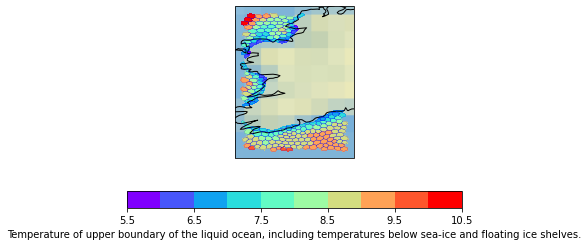

In [19]:
psy.plot.mapplot(
    dset, name="tos", cmap='rainbow',
    lonlatbox='Ireland',
    clabel=dset["tos"].description,
    stock_img=True,
    lsm='50m',
    datagrid=dict(c='b', lw=0.2)).show()

In [17]:
dset.close()

### Used data

- [Semmler et al., 2019: AWI AWI-CM1.1MR model output prepared for CMIP6](https://doi.org/10.22033/ESGF/CMIP6.2803)

We acknowledge the CMIP community for providing the climate model data, retained and globally distributed in the framework of the ESGF. The CMIP data of this study were replicated and made available for this study by the DKRZ.”